In [2]:
import pandas as pd
import numpy as np
import time
from scipy.sparse import dok_matrix
from scipy.sparse import coo_matrix
import scipy.sparse 
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster, metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import preprocessing

## UA matrix

In [2]:
word=pd.read_csv('/Users/johnson/Desktop/womany/womany-shop/data/word/articles_bq-results-20191018-120757-rz4vi3ny9up5.csv')
tags=pd.read_csv('/Users/johnson/Desktop/womany/womany-shop/data/word/keywords_bq-results-20191016-105842-gjfe3oczpgba.csv')
hits=pd.read_csv('/Users/johnson/Desktop/womany/womany-shop/data/word/hits_bq-results-20191018-124800-x9nh5wotdsrv.csv')

In [3]:
u_arr=np.sort(hits['user_id'].unique())
a_arr=np.sort(hits['param_id'].unique())

In [4]:
u_arr.shape

(83047,)

In [5]:
a_arr.shape

(17044,)

## AK matrix

In [6]:
a_k_merge=pd.merge(word,tags,on='id',how='inner')

In [7]:
a_k_merge=a_k_merge.rename(columns={'description_x':'description','id':'article_id'})

In [8]:
a_k_df=a_k_merge[['article_id', 'description',
        'name', 'created_at', 'updated_at']]
a_k_df=a_k_df.loc[a_k_df['article_id'].isin(a_arr)]

In [9]:
a_k_df['count']=1
a_k=a_k_df.pivot_table(index='name', columns='article_id', values='count').fillna(0)

In [ ]:
a_k=a_k.T.astype(int)

In [ ]:
k_arr=np.sort(a_k.T.index.unique())

## UK matrix (sparse matrix)

In [ ]:
def sparse_martix_u_a(hits):
    t0 = time.time()
    dict_u_a = {}
    for idx, row in hits.iterrows():
        u_idx = np.where(u_arr == row['user_id'])[0][0]
        a_idx = np.where(a_arr == row['param_id'])[0][0]

        if dict_u_a.get((u_idx, a_idx), 0) == 0:
            dict_u_a[(u_idx, a_idx)] = 1
        elif dict_u_a.get((u_idx, a_idx), 0) > 0:
            dict_u_a[(u_idx, a_idx)] += 1

    print(time.time() - t0)
    return dict_u_a

In [ ]:
dict_u_a = sparse_martix_u_a(hits)

In [ ]:
### from sparse dict get rows
def get_3x1darray_row(dict_x):
    row=[]
    for (r1,c1), v1 in dict_x.items():
        row.append(r1)
    return np.asarray(row)

### from sparse dict get cols
def get_3x1darray_col(dict_x):
    col=[]
    for (r1,c1), v1 in dict_x.items():
        col.append(c1)
    return np.asarray(col)

### from sparse dict get vals
def get_3x1darray_val(dict_x):
    val=[]
    for (r1,c1), v1 in dict_x.items():
        val.append(v1)
    return np.asarray(val)

In [ ]:
u_a_row=get_3x1darray_row(dict_u_a)
u_a_col=get_3x1darray_col(dict_u_a)
u_a_val=get_3x1darray_val(dict_u_a)

In [ ]:
coo_u_a=coo_matrix((u_a_val, (u_a_row, u_a_col)), shape=(len(u_arr), len(a_arr)))

In [ ]:
coo_a_k=coo_matrix(a_k.values)
# u_a_k=get_3x1darray_row(dict_a_k)

In [92]:
t1 = time.time()

coo_u_k_sparse_matrix=coo_u_a*coo_a_k

print(time.time() - t1)

1.8169682025909424


In [94]:
u_k_arr=coo_u_k_sparse_matrix.todense()

## load uk matrix

In [3]:
### loading data
coo_u_k_sparse_matrix_test=scipy.sparse.load_npz('/Users/johnson/Desktop/womany/womany-shop/data/user_keywords/coo_u_k_sparse_matrix.npz')
user_array=np.load('/Users/johnson/Desktop/womany/womany-shop/data/user_keywords/user_array.npy')
keywords_array=np.load('/Users/johnson/Desktop/womany/womany-shop/data/user_keywords/keywords_array.npy')

user_keywords_array=coo_u_k_sparse_matrix_test.todense()

In [4]:
u_k_df=pd.DataFrame(user_keywords_array,columns=keywords_array).set_index(user_array,drop=False)

In [5]:
df=u_k_df

In [ ]:
# for i in range(len(u_k_df_new)):
#     tmp=u_k_df_new.iloc[i,:].div(u_k_df_new.iloc[i,:].sum())
#     tmp_p=tmp*100
#     u_k_df_new.iloc[i,:]=tmp_p

In [6]:
time1=time.time()
uk_div_df=df.div(df.sum(axis=1), axis=0).fillna(0)
print(time.time()-time1)

31.11707592010498


In [15]:
uk_percentage_df=uk_div_df*100

## hard clustering V2 (with percentage)

In [23]:
cluster_list=uk_percentage_df.T.to_numpy()

distortions = []
models={}

time1=time.time()

K = [50,90]
for k in K:
    print("Now processing:",k)
    kmeanModel = KMeans(n_clusters=k).fit(cluster_list)
    models[k]=kmeanModel.fit(cluster_list)
    distortions.append(sum(np.min(cdist(cluster_list, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / cluster_list.shape[0])


print(time.time()-time1)

Now processing: 50
Now processing: 90
5459.016459941864


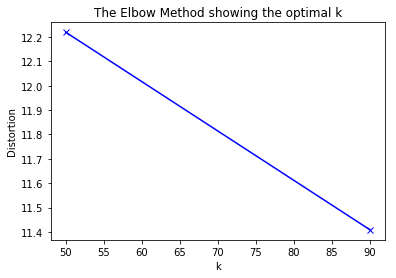

In [25]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


## K=50

In [26]:
#means_fit = cluster.KMeans(n_clusters = 50).fit(cluster_list)
#cluster_labels = means_fit.labels_
cluster_labels50=models[50].labels_
print("分群結果：")
print(cluster_labels50)
print("---")

分群結果：
[22 22 22 ... 22 22 22]
---


In [32]:
cluster_labels50_df=pd.DataFrame(cluster_labels50,columns=['cluster_labels'])
uk_percentage_df_T=uk_percentage_df.T.reset_index(drop=True)
uk_percentage_df_T_new=uk_percentage_df_T.reset_index(drop=True)
cluster_result50=pd.concat([uk_percentage_df_T_new,cluster_labels50_df],axis=1)


In [35]:
cluster_result50['key_words']=uk_percentage_df.T.index

In [37]:
cluster_result50_final=cluster_result50[['key_words','cluster_labels']]

In [39]:
cluster_result50_final['cluster_labels'].value_counts()

22    4665
0      356
16     113
7       34
14      34
18      31
42      21
20      21
44      16
36      13
37       9
38       9
11       8
1        7
48       7
12       7
31       5
9        4
4        4
47       4
23       4
5        3
32       3
29       2
28       2
19       2
13       2
26       2
2        2
43       2
33       1
30       1
39       1
8        1
35       1
27       1
6        1
24       1
49       1
40       1
15       1
3        1
46       1
10       1
34       1
41       1
17       1
21       1
25       1
45       1
Name: cluster_labels, dtype: int64

In [52]:
cluster_result50_final.loc[cluster_result50_final['cluster_labels']==0]

,key_words,cluster_labels
6,09,0
67,26,0
71,28,0
75,29,0
101,36,0
132,70,0
179,Bar,0
188,Can,0
211,Fu,0
214,Get,0


## K=90

In [41]:
#means_fit = cluster.KMeans(n_clusters = 50).fit(cluster_list)
#cluster_labels = means_fit.labels_
cluster_labels90=models[90].labels_
print("分群結果：")
print(cluster_labels90)
print("---")

分群結果：
[15 15 15 ... 15 15 15]
---


In [42]:
cluster_labels90_df=pd.DataFrame(cluster_labels90,columns=['cluster_labels'])
uk_percentage_df_T=uk_percentage_df.T.reset_index(drop=True)
uk_percentage_df_T_new=uk_percentage_df_T.reset_index(drop=True)
cluster_result90=pd.concat([uk_percentage_df_T_new,cluster_labels90_df],axis=1)


In [43]:
cluster_result90['key_words']=uk_percentage_df.T.index

In [44]:
cluster_result90_final=cluster_result90[['key_words','cluster_labels']]

In [45]:
cluster_result90_final['cluster_labels'].value_counts()

15    4812
0      246
73      31
33      28
76      28
11      23
71      21
27      20
66      15
70      15
89      15
82      14
36      13
19      13
12       7
54       6
55       4
68       4
16       4
53       4
57       3
46       3
61       2
38       2
29       2
77       2
25       2
21       2
83       2
88       2
      ... 
8        1
4        1
9        1
17       1
34       1
43       1
50       1
26       1
22       1
18       1
14       1
10       1
6        1
2        1
58       1
62       1
81       1
74       1
78       1
69       1
65       1
7        1
49       1
23       1
41       1
37       1
31       1
35       1
39       1
87       1
Name: cluster_labels, Length: 90, dtype: int64

## get list

In [54]:
for i in df.columns:
    str(i)

In [56]:
cluster_user_list_dict50={}
for i in range(len(cluster_result50_final['cluster_labels'].unique())):
    cluster_user_list_dict50[i]=cluster_result50_final.loc[cluster_result50_final['cluster_labels']==i]
    try:
        cluster_user_list_dict50[i]=df[cluster_user_list_dict50[i]['key_words']]
    except Exception as e: 
        print(e)
    cluster_user_list_dict50[i]=cluster_user_list_dict50[i].loc[~(cluster_user_list_dict50[i]==0).all(axis=1)]

In [67]:
for i in cluster_user_list_dict50:
    print(i,cluster_user_list_dict50[i].shape[0])

0 78006
1 77908
2 68720
3 68761
4 72845
5 73272
6 64225
7 81339
8 71221
9 61053
10 70293
11 59222
12 72150
13 71553
14 75784
15 72273
16 77617
17 81824
18 75907
19 72206
20 66796
21 66291
22 77438
23 68776
24 57026
25 70985
26 77110
27 67289
28 79182
29 75532
30 67229
31 72760
32 76564
33 73028
34 57826
35 73109
36 70783
37 74085
38 71906
39 65061
40 64417
41 59103
42 74726
43 74905
44 71853
45 47682
46 67463
47 73985
48 75007
49 75130


In [68]:
cluster_user_list_dict90={}
for i in range(len(cluster_result90_final['cluster_labels'].unique())):
    cluster_user_list_dict90[i]=cluster_result90_final.loc[cluster_result90_final['cluster_labels']==i]
    try:
        cluster_user_list_dict90[i]=df[cluster_user_list_dict90[i]['key_words']]
    except Exception as e: 
        print(e)
    cluster_user_list_dict90[i]=cluster_user_list_dict90[i].loc[~(cluster_user_list_dict90[i]==0).all(axis=1)]

In [69]:
for i in cluster_user_list_dict90:
    print(i,cluster_user_list_dict90[i].shape[0])

0 77429
1 59097
2 67289
3 77110
4 56334
5 55981
6 73409
7 69240
8 68763
9 71221
10 56739
11 78520
12 49395
13 40179
14 67754
15 76990
16 67731
17 57993
18 73028
19 70952
20 71547
21 41229
22 73109
23 76144
24 70293
25 73138
26 63489
27 73102
28 68255
29 57257
30 62147
31 66149
32 64401
33 74808
34 62046
35 65061
36 71502
37 56332
38 53686
39 60359
40 72273
41 67462
42 50695
43 81824
44 71969
45 68492
46 71003
47 75130
48 58715
49 62786
50 72820
51 59103
52 60819
53 69555
54 57026
55 70208
56 41988
57 56644
58 50556
59 34035
60 67463
61 72553
62 72061
63 66675
64 59705
65 57826
66 69894
67 65475
68 68390
69 62076
70 65181
71 66796
72 66291
73 55445
74 54616
75 55615
76 75604
77 58904
78 55230
79 68980
80 57520
81 50055
82 70826
83 64554
84 61689
85 67855
86 63538
87 58786
88 69389
89 73588


In [79]:
cluster_result90_final['cluster_labels'].value_counts()

15    4812
0      246
73      31
33      28
76      28
11      23
71      21
27      20
66      15
70      15
89      15
82      14
36      13
19      13
12       7
54       6
55       4
68       4
16       4
53       4
57       3
46       3
61       2
38       2
29       2
77       2
25       2
21       2
83       2
88       2
      ... 
8        1
4        1
9        1
17       1
34       1
43       1
50       1
26       1
22       1
18       1
14       1
10       1
6        1
2        1
58       1
62       1
81       1
74       1
78       1
69       1
65       1
7        1
49       1
23       1
41       1
37       1
31       1
35       1
39       1
87       1
Name: cluster_labels, Length: 90, dtype: int64

In [96]:
df_sum=df.sum(axis=1)